In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# explore data base
# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print()
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])    

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# Use `engine.execute` to select and display the first 5 rows from the tables
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [9]:
# Use `engine.execute` to select and display the first 5 rows from the tables
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables


In [11]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [12]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [71]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(func.max(measurement.date)).one()
latest_date

('2017-08-23')

In [16]:
# Perform a query to retrieve the date and precipitation scores
precip = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date>='2016-08-23').all()

In [43]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# delete null values
precip_df = pd.DataFrame(precip).set_index('date').dropna()
# convert date string to date
precip_df.index = pd.to_datetime(precip_df.index)
# check all worked
precip_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [44]:
precip_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2021 entries, 2016-08-23 to 2017-08-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   prcp    2021 non-null   float64
dtypes: float64(1)
memory usage: 31.6 KB


In [45]:
# Sort the dataframe by date
precip_df_sorted = precip_df.sort_values('date')




<function matplotlib.pyplot.show(*args, **kw)>

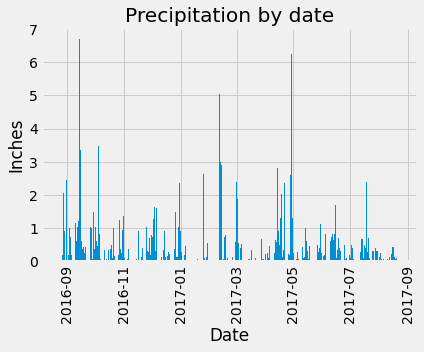

In [49]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precip_df_sorted.index, precip_df_sorted.prcp)
plt.ylabel("Inches")
plt.xlabel("Date")
plt.title("Precipitation by date")
plt.xticks(rotation = 90)
plt.style.use('fivethirtyeight')

plt.show

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [52]:
# Design a query to show how many stations are available in this dataset?
no_stations = session.query(station.station).distinct().count()
no_stations
    

9

In [62]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
from sqlalchemy import desc
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
        order_by(desc(func.count(measurement.station))).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [77]:
# most active station
most_active_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
        order_by(desc(func.count(measurement.station))).limit(1).all()
most_active_station

'USC00519281'

In [81]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_low = session.query(func.min(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').scalar()
print(f"lowest recorded temperature at {most_active_station[0][0]} is {temp_low} F")

temp_high = session.query(func.max(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').scalar()
print(f"highest recorded temperature at {most_active_station[0][0]} is {temp_high} F")

temp_avg = session.query(func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').scalar()
print(f"average recorded temperature at {most_active_station[0][0]} is {round(temp_avg, 1)} F")

lowest recorded temperature at USC00519281 is 54.0 F
highest recorded temperature at USC00519281 is 85.0 F
average recorded temperature at USC00519281 is 71.7 F


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
